In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import torch
import torchaudio
from tqdm import tqdm
import librosa

from IPython.display import Audio

tqdm.pandas()

import sklearn
from sklearn.utils.class_weight import compute_class_weight

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import torch.nn as nn
from torch.utils.data import random_split
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from speechbrain.inference import EncoderClassifier

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [2]:
cv_train_tab = pd.read_csv('./cv-archive/cv-valid-train.csv')
cv_test_tab = pd.read_csv('./cv-archive/cv-valid-test.csv')

print(cv_train_tab.shape)
print(cv_test_tab.shape)

cv_train_tab = cv_train_tab.dropna(subset=['accent'])
cv_test_tab = cv_test_tab.dropna(subset=['accent'])

print(cv_train_tab.shape)
print(cv_test_tab.shape)

cv_train_tab.head()

(195776, 8)
(3995, 8)
(64711, 8)
(1338, 8)


,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should never forget about his sheep,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to miss out on an opportunity,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhouette appeared in the doorway,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


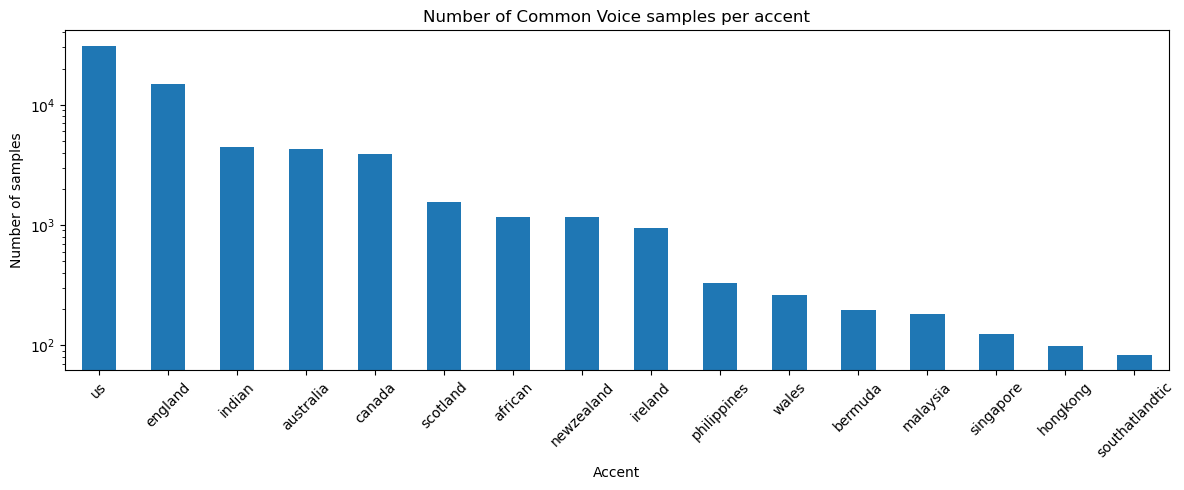

In [3]:
plt.figure(figsize=(12,5))

cv_train_tab['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.savefig('./pictures/cv_accents_bar.png',format='png')
plt.show()

In [4]:
cv_test_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of people sleeping in peace,4,0,twenties,male,us,NaN
5,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of people sleeping in peace,4,1,twenties,male,us,NaN
8,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever came to earth from outer space,1,0,thirties,male,england,NaN
9,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky nor a breath of wind,3,0,fifties,male,us,NaN
14,cv-valid-test/sample-000014.mp3,follow the instructions here,1,0,twenties,male,scotland,NaN


In [5]:
CORES = multiprocessing.cpu_count() # Count the number of cores in a computer
print(CORES)

12


In [6]:
# multiprocessing.set_start_method('fork')

def f(x): 
    return x + 1 

with multiprocessing.Pool() as pool: 
    print(pool.map(f, range(10))) 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [7]:
def add_path_train(filename):
    path_to_train = './cv-archive/cv-valid-train/'
    if path_to_train not in filename:
        filename = path_to_train+filename
    return(filename)

cv_train_tab['filename'] = cv_train_tab.filename.apply(add_path_train) 
cv_train_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,./cv-archive/cv-valid-train/cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should never forget about his sheep,1,0,twenties,female,us,NaN
8,./cv-archive/cv-valid-train/cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,./cv-archive/cv-valid-train/cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to miss out on an opportunity,1,0,thirties,female,us,NaN
14,./cv-archive/cv-valid-train/cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhouette appeared in the doorway,1,0,sixties,male,england,NaN
19,./cv-archive/cv-valid-train/cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


In [8]:
def add_path_test(filename):
    path_to_test = './cv-archive/cv-valid-test/'
    if path_to_test not in filename:
        filename = path_to_test+filename
    return(filename)

cv_test_tab['filename'] = cv_test_tab.filename.apply(add_path_test) 
cv_test_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
3,./cv-archive/cv-valid-test/cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of people sleeping in peace,4,0,twenties,male,us,NaN
5,./cv-archive/cv-valid-test/cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of people sleeping in peace,4,1,twenties,male,us,NaN
8,./cv-archive/cv-valid-test/cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever came to earth from outer space,1,0,thirties,male,england,NaN
9,./cv-archive/cv-valid-test/cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky nor a breath of wind,3,0,fifties,male,us,NaN
14,./cv-archive/cv-valid-test/cv-valid-test/sample-000014.mp3,follow the instructions here,1,0,twenties,male,scotland,NaN


## screening data for duration 
some of the data are extra long, so we need to trim those out

In [9]:
def pull_metadata(filename):
  try:
    metadata = torchaudio.info(filename)
    length = metadata.num_frames / metadata.sample_rate
    return(length)
  except:
    return(float('NaN'))

print(cv_test_tab.iloc[0].filename)

metadata = pull_metadata(cv_train_tab.iloc[0].filename)
print(metadata)

./cv-archive/cv-valid-test/cv-valid-test/sample-000003.mp3
5.836125


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(


In [10]:
pool = multiprocessing.Pool(CORES)
train_lengths = pool.map(pull_metadata, cv_train_tab.filename)
test_lengths = pool.map(pull_metadata, cv_test_tab.filename)
pool.close()

In [11]:
index_meta, = np.where(~np.isnan(train_lengths))
index_nometa,= np.where(np.isnan(train_lengths))

print(len(index_meta),len(index_nometa))

train_lengths = np.array(train_lengths)
test_lengths = np.array(test_lengths)

64711 0


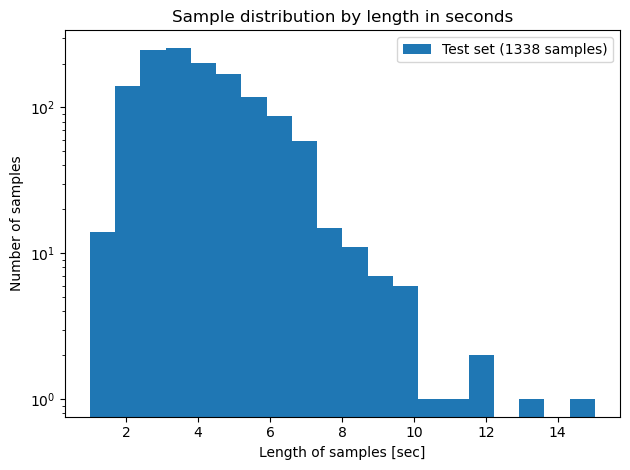

15.028125


In [12]:
plt.hist(test_lengths,bins=20,
         label='Test set ('+str(len(test_lengths))+' samples)')
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Length of samples [sec]')
plt.title('Sample distribution by length in seconds')
plt.legend()
plt.tight_layout()
plt.savefig('./pictures/cv_test_length_hist.png',format='png')
plt.show()

print(np.max(test_lengths))

64711 64699


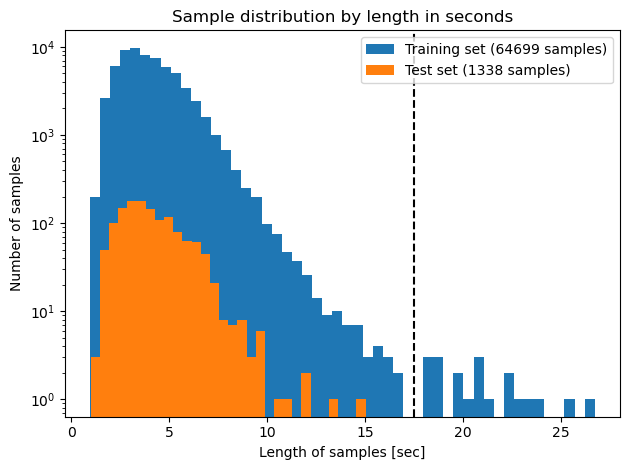

In [13]:
index_long, = np.where(train_lengths < 30)

print(len(index_meta),len(index_long))

plt.hist(train_lengths[index_long],bins=50,
         label='Training set ('+str(len(train_lengths[index_long]))+\
         ' samples)')
plt.hist(test_lengths,bins=30,
         label='Test set ('+str(len(test_lengths))+' samples)')

CUTOFF = 17.5

plt.axvline(CUTOFF,ls='--',color='k')

plt.yscale('log')

plt.ylabel('Number of samples')
plt.xlabel('Length of samples [sec]')
plt.title('Sample distribution by length in seconds')
plt.legend()
plt.tight_layout()
plt.savefig('./pictures/cv_train_length_hist.png',format='png')
plt.show()

In [14]:
if 'length' not in cv_train_tab:
    cv_train_tab['length'] = train_lengths

cv_test_tab['length'] = test_lengths

print(cv_train_tab.shape)
print(cv_train_tab[cv_train_tab.length<CUTOFF].shape)

cv_train_tab = cv_train_tab[cv_train_tab.length<CUTOFF]

cv_train_tab.head()

(64711, 9)
(64679, 9)


,filename,text,up_votes,down_votes,age,gender,accent,duration,length
5,./cv-archive/cv-valid-train/cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should never forget about his sheep,1,0,twenties,female,us,NaN,5.836125
8,./cv-archive/cv-valid-train/cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN,1.732125
13,./cv-archive/cv-valid-train/cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to miss out on an opportunity,1,0,thirties,female,us,NaN,4.228125
14,./cv-archive/cv-valid-train/cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhouette appeared in the doorway,1,0,sixties,male,england,NaN,5.380125
19,./cv-archive/cv-valid-train/cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,3.740125


## quality control

In [15]:
print(cv_train_tab[cv_train_tab.down_votes>0].shape)
print(cv_train_tab[cv_train_tab.down_votes==0].shape)
print(cv_train_tab[cv_train_tab.up_votes>cv_train_tab.down_votes].shape)

print(cv_test_tab[cv_test_tab.down_votes==0].shape)

(5419, 9)
(59260, 9)
(64669, 9)
(1217, 9)


In [16]:
cv_train_tab = cv_train_tab[cv_train_tab.down_votes==0]
cv_test_tab = cv_test_tab[cv_test_tab.down_votes==0]

print(cv_train_tab.shape,cv_test_tab.shape)

(59260, 9) (1217, 9)


In [17]:
ACCENTS = ['us','england','scotland','australia','ireland','canada']#,'wales',]
ACCENTS = ['us','england','scotland','australia','ireland','canada']
# ACCENTS = ['england','australia']

print(cv_train_tab[cv_train_tab.accent.isin(ACCENTS)].shape)
print(cv_train_tab.shape)

print(cv_test_tab[cv_test_tab.accent.isin(ACCENTS)].shape)
print(cv_test_tab.shape)

(52094, 9)
(59260, 9)
(1077, 9)
(1217, 9)


In [18]:
cv_train_tab = cv_train_tab[cv_train_tab.accent.isin(ACCENTS)]
cv_test_tab = cv_test_tab[cv_test_tab.accent.isin(ACCENTS)]

In [19]:
label2id, id2label = dict(), dict()
for i, label in enumerate(ACCENTS):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

cv_train_tab['label'] = cv_train_tab['accent'].apply(lambda x: label2id[x])
cv_test_tab['label'] = cv_test_tab['accent'].apply(lambda x: label2id[x])

cv_train_tab.head()

{0: 'us', 1: 'england', 2: 'scotland', 3: 'australia', 4: 'ireland', 5: 'canada'} 

 {'us': 0, 'england': 1, 'scotland': 2, 'australia': 3, 'ireland': 4, 'canada': 5}


,filename,text,up_votes,down_votes,age,gender,accent,duration,length,label
5,./cv-archive/cv-valid-train/cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should never forget about his sheep,1,0,twenties,female,us,NaN,5.836125,0
8,./cv-archive/cv-valid-train/cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN,1.732125,0
13,./cv-archive/cv-valid-train/cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to miss out on an opportunity,1,0,thirties,female,us,NaN,4.228125,0
14,./cv-archive/cv-valid-train/cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhouette appeared in the doorway,1,0,sixties,male,england,NaN,5.380125,1
19,./cv-archive/cv-valid-train/cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,3.740125,3


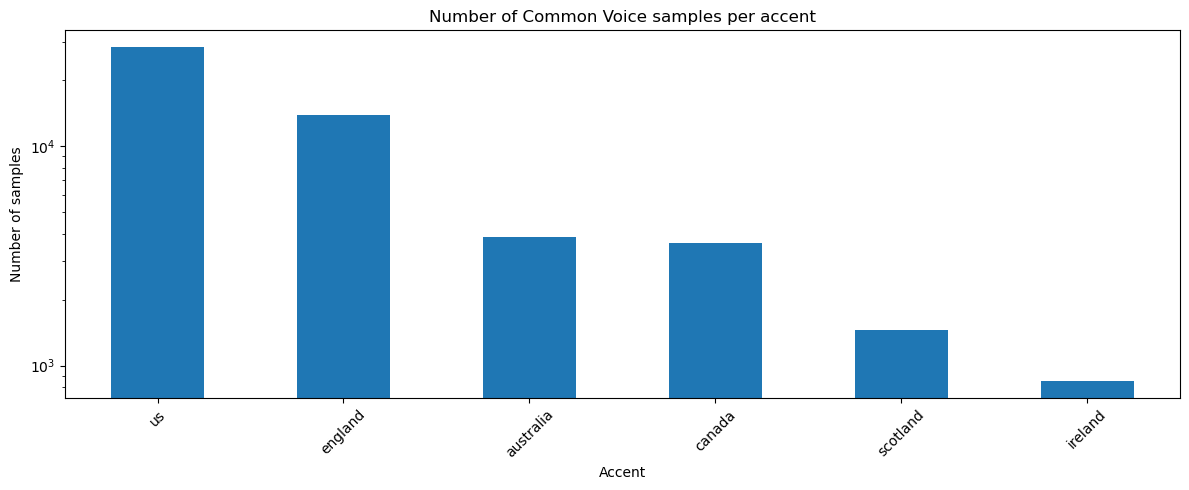

In [20]:
plt.figure(figsize=(12,5))

cv_train_tab['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.title('Number of Common Voice samples per accent')
plt.savefig('./pictures/cv_train_accents_bar.png',format='png')
plt.show()

In [21]:
rus = RandomUnderSampler(random_state=83, sampling_strategy='auto')
# ros = RandomOverSampler(random_state=83, sampling_strategy='all')
y = cv_train_tab['label']
cv_train_tab_rus = cv_train_tab.drop(['label'], axis=1)
cv_train_tab_rus, y_resampled = rus.fit_resample(cv_train_tab, y)
del y
cv_train_tab_rus['label'] = y_resampled
del y_resampled

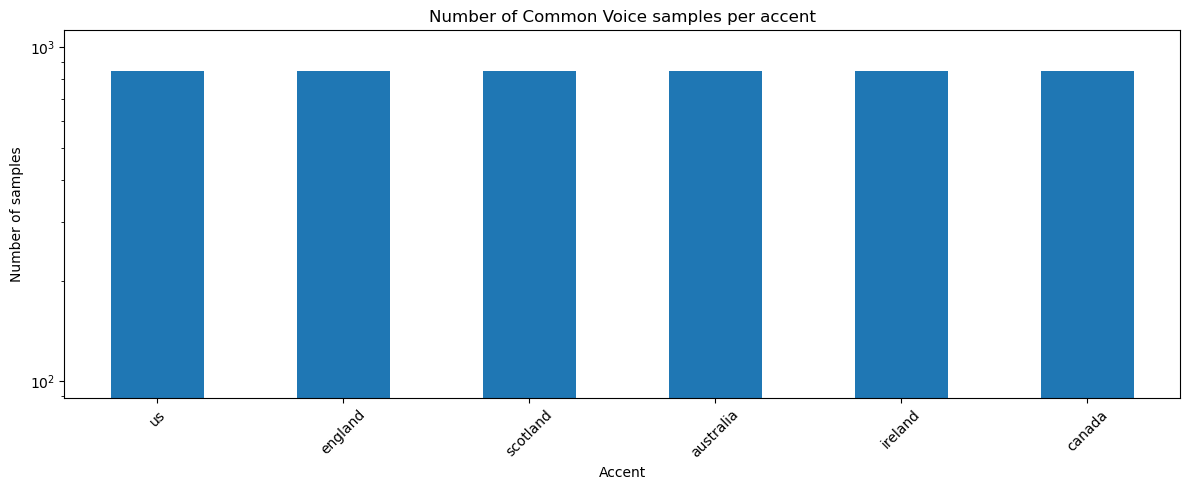

In [22]:
plt.figure(figsize=(12,5))

cv_train_tab_rus['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.show()

In [23]:
weights = compute_class_weight(class_weight='balanced', classes=np.array(ACCENTS), y=cv_train_tab['accent'])
class_weights = dict(zip(ACCENTS, weights))
print(class_weights)

{'us': 0.30611477394257774, 'england': 0.6235516613999809, 'scotland': 5.946803652968036, 'australia': 2.2423381542699725, 'ireland': 10.22654102866117, 'canada': 2.3944658944658945}


In [24]:
cv_train_tab = cv_train_tab_rus

# looking at the data

In [25]:
lookat_file = cv_test_tab.iloc[3]
lookat_file

filename      ./cv-archive/cv-valid-test/cv-valid-test/sample-000014.mp3
text                                        follow the instructions here
up_votes                                                               1
down_votes                                                             0
age                                                             twenties
gender                                                              male
accent                                                          scotland
duration                                                             NaN
length                                                          2.324125
label                                                                  2
Name: 14, dtype: object

torch.Size([1, 257, 145])


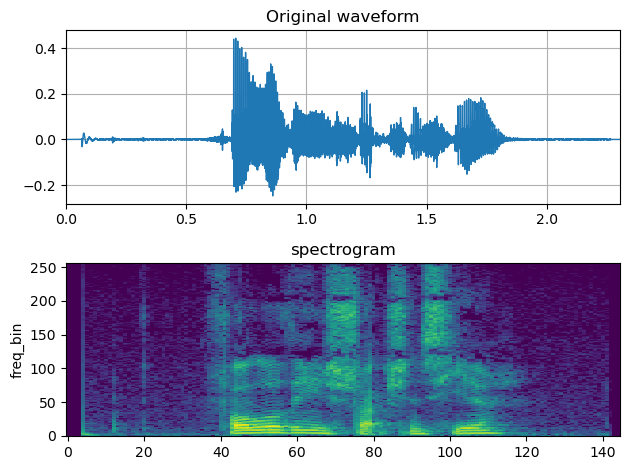

In [26]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    
waveform, sample_rate = torchaudio.load(lookat_file.filename)

NFFT = 512
RESAMPLE_RATE=16000
spectrogram = torchaudio.transforms.Spectrogram(n_fft=NFFT)

# Perform transform
transform = torchaudio.transforms.Resample(sample_rate, RESAMPLE_RATE)
audio_prime = transform(waveform)

spec = spectrogram(audio_prime)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()
plt.savefig('./pictures/waveform_spectrogram.png',format='png')

print(spec.shape)

from IPython.display import Audio 
Audio(audio_prime.numpy()[0], rate=RESAMPLE_RATE)


# running the pretrained model

In [27]:
# Load the ECAPA-TDNN based accent classifier
classifier = EncoderClassifier.from_hparams(
    source="Jzuluaga/accent-id-commonaccent_ecapa",
    savedir="pretrained_models/accent-id-ecapa"
)
# Classify the audio
out_prob, score, index, text_lab = classifier.classify_file(lookat_file.filename)

# Print results
print(f"Predicted Accent: {text_lab[0]}")

/opt/anaconda3/lib/python3.12/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
CategoricalEncoder.expect_len was never called: assuming category count of 16 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.


Predicted Accent: scotland


In [28]:
def classify_pretrained(file):
    out_prob, score, index, text_lab = classifier.classify_file(file)
    return(text_lab[0])

pool = multiprocessing.Pool(CORES)
predict_accent = []
for result in tqdm(pool.imap(classify_pretrained, cv_test_tab.filename), total=len(cv_test_tab.filename)):
    predict_accent.append(result)
pool.close()

100%|███████████████████████████████████████| 1077/1077 [00:22<00:00, 47.37it/s]


accuracy: 0.9545032497678737


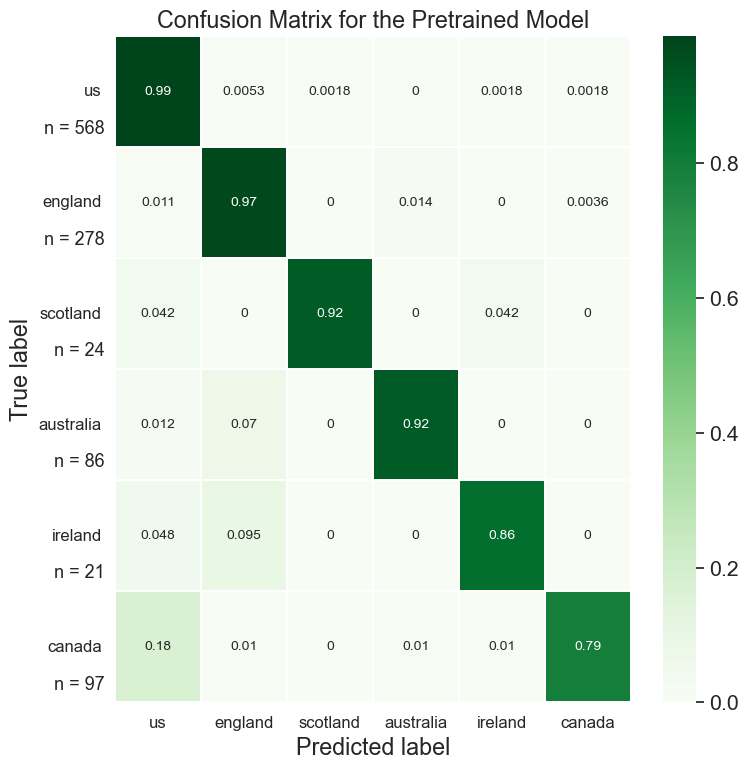

In [29]:
print(f"accuracy: {np.sum(predict_accent == cv_test_tab.accent)/len(cv_test_tab.filename)}")

class_names = ACCENTS
matrix = confusion_matrix(cv_test_tab['accent'],predict_accent,labels=class_names)
num_true = matrix.sum(axis=1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names,fontsize=12)
plt.yticks(tick_marks2, class_names, rotation=0,fontsize=12)
for i in range(len(num_true)):
    plt.text(-0.12,tick_marks2[i]+0.38,'n = '+ str(num_true[i]),ha='right',fontsize=13)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for the Pretrained Model')
plt.tight_layout()
plt.savefig('./pictures/pretrained_confusion.png',format='png')
plt.show()

# spectral datasets

In [30]:
class SpectralDataset:
    def __init__(self, df, sample_rate=RESAMPLE_RATE, max_duration=CUTOFF,nfft=NFFT):
        self.df = df.copy(deep=True)
        self.sample_rate = sample_rate
        self.max_length = int(sample_rate * max_duration)  # e.g., 5 seconds
        self.label_encoder = LabelEncoder()
        self.nfft = nfft
        self.spectrogram = torchaudio.transforms.Spectrogram(n_fft=self.nfft)
        self.df['accent'] = self.label_encoder.fit_transform(df['accent'])
        self.accent_id = dict(enumerate(self.label_encoder.classes_))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['filename']
        label = row['accent']

        # Load audio
        wav, sr = torchaudio.load(path)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            wav = resampler(wav)

        # Remove channel dimension
        wav = wav.squeeze(0)

        # Truncate or pad as needed
        num_samples = self.max_length
        if wav.shape[0] > num_samples:
            wav = wav[:num_samples]
        elif wav.shape[0] < num_samples:
            pad_len = num_samples - wav.shape[0]
            wav = torch.nn.functional.pad(wav, (0, pad_len))

        wav = wav.unsqueeze(0)

        ## cleaning the data    
        wav += -1*torch.median(wav)
        wav *= 1/torch.max(wav)

        ## turning into spectrogram
        spec = self.spectrogram(wav)
        
        return spec, torch.tensor(label, dtype=torch.long)

# Defining the model

In [31]:
NFFT = 512
CUTOFF = 7.5
RESAMPLE_RATE = 16000

train_df, val_df = train_test_split(
    cv_train_tab,
    test_size=0.2,
    stratify=cv_train_tab['accent'],  # ensures all classes are represented
    random_state=42
)

train_ds = SpectralDataset(train_df,nfft=NFFT,sample_rate=RESAMPLE_RATE)
val_ds = SpectralDataset(val_df,nfft=NFFT,sample_rate=RESAMPLE_RATE)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=64)
val_dl = DataLoader(val_ds, batch_size=64)
dls = DataLoaders(train_dl, val_dl)

# Set up model
num_accents = len(ACCENTS)
features = 32

initial_2d = (int(np.ceil(RESAMPLE_RATE*CUTOFF/NFFT*2)),int(NFFT/2+1),)

sample_input, _ = train_ds[0]
data_dim = np.prod(sample_input.shape)

xb,yb = first(dls.valid)

conv_net = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(1, 2, kernel_size=(1,7), padding=0,stride=(1,4)),
        nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        # nn.MaxPool2d(2),
        nn.Conv2d(2, 4, kernel_size=(1,3), padding=0,stride=(1,3)),
        nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        # nn.MaxPool2d(2),
        nn.Conv2d(4, 8, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(16, 2, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(1280,64),
        nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Linear(64,2*num_accents),
        nn.BatchNorm1d(2*num_accents, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Linear(2*num_accents,num_accents),
        )

conv_net(xb).shape
learn = Learner(dls, conv_net, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn.summary()


Sequential (Input shape: 64 x 1 x 257 x 1094)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 1 x 257 x 1094 
BatchNorm2d                               2          True      
____________________________________________________________________________
                     64 x 2 x 257 x 272  
Conv2d                                    16         True      
BatchNorm2d                               4          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 4 x 257 x 90   
Conv2d                                    28         True      
BatchNorm2d                               8          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 257 x 44   
Conv2d                                    1

In [32]:
learn.load('../model_save_convnet')

In [33]:
test_ds = SpectralDataset(cv_test_tab)
test_dl = DataLoader(test_ds, batch_size=64)
preds, _ = learn.get_preds(dl=test_dl)
pred_classes = preds.argmax(dim=1)

In [34]:
accuracy_testset = accuracy_score(test_ds.df['accent'],pred_classes)
print(f"accuracy: {accuracy_testset}")

accuracy: 0.2488393686165274


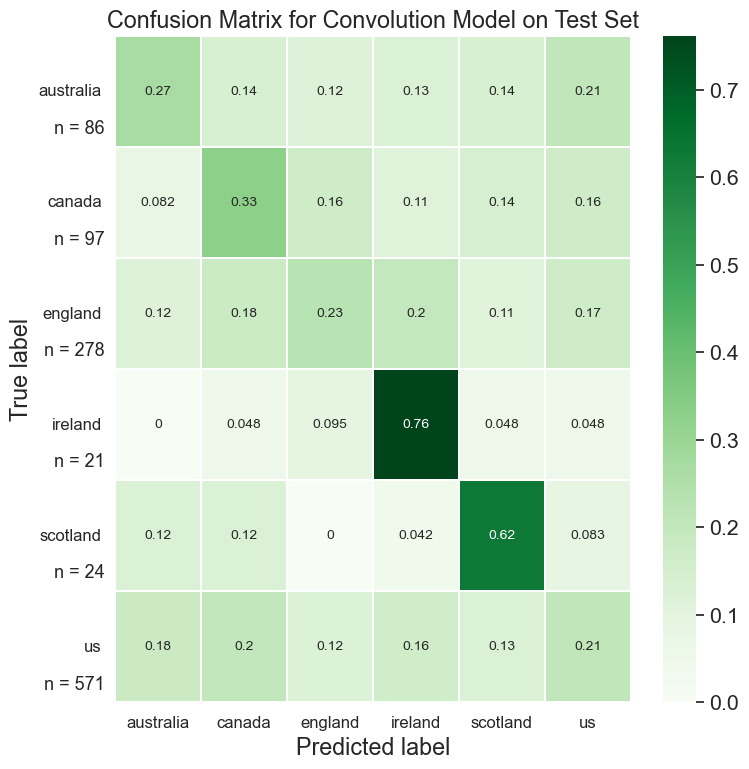

In [35]:
matrix = confusion_matrix(test_ds.df['accent'],pred_classes)
num_true = matrix.sum(axis=1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
class_names = test_ds.accent_id.values()
# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names,fontsize=12)
plt.yticks(tick_marks2, class_names, rotation=0,fontsize=12)
for i in range(len(num_true)):
    plt.text(-0.12,tick_marks2[i]+0.38,'n = '+ str(num_true[i]),ha='right',fontsize=13)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Convolution Model on Test Set')
plt.tight_layout()
plt.savefig('./pictures/cv_test_confusion.png',format='png')
plt.show()